# Example use of the Signature Simulator
In this demo we will begin by using the Signature Simulator to forward model some Sentinel 1 and 2 backscatters and reflectances. We will then show the Retreival Tool which inverts the Signature Simulator to produce some estimates of Leaf Area Index (LAI), soil moisture and canopy height for a set of fields near Munich, Germany.
## Example 1 - Calculating reflectance and backscatter values for a single aquisition
In this example we will simulate Sentinel 2 reflectance values and Sentinel 1 backscatter values for a given satellite geometry and land surface state. From an interactive console we first import the signaturesimulator package and setup an instance of the Simulator class:

In [50]:
import signaturesimulator as ss
sim = ss.Simulator()

We can now set the viewing geometries and time of the satellite observation, to do this we also need to specify a Python datetime object so we will also import the datetime module:

In [51]:
import datetime as dt  # part of standard Python distribution
sim.get_geom = sim.geom_default(date_utc=dt.datetime(2016,6,17,10,25), vza=5.5, vaa=286.3, sza=26.8, saa=157.0)

Where vza and vaa are the view zenith and azimuth angles and sza and saa are the solar zenith and azimuth angles. We must now specify the land surface state variables for which to calculate Sentinel 2 reflectance values:

In [52]:
sim.get_land_state = sim.state_default(date_utc=dt.datetime(2016,6,17,9,0), lai=3.0, canopy_ht=1.0, soil_m=0.3)

Where lai is leaf are index (m$^2$ m$^{-2}$), canpopy_ht is vegetation canopy height (m) and soil_m is the top layer soil moisture (m$^3$ m$^{-3}$). We now specify the radiative transfer model we want to use and then run the simulator (currently there is the choice between active microwave and passive optical with these models being setup for the Sentinel 1 and 2 missions respectively). Here we are interested in reflectance, so set the following:

In [53]:
sim.run_rt = sim.passive_optical
sim.run()  # Running a canopy radiative transfer model, convolving output with spectral response functions of Sentinel 2

Once the simulator has finished its run it will write the output to a new spectra class. We can then look at the reflectance values for different bands (ordered by wavelength) using the following command:

In [55]:
sim.spectra.refl

[array([0.018664, 0.020378, 0.026745, 0.02097 , 0.035889, 0.213055,
        0.332095, 0.338523, 0.343047, 0.337906, 0.230565, 0.192891,
        0.086688])]

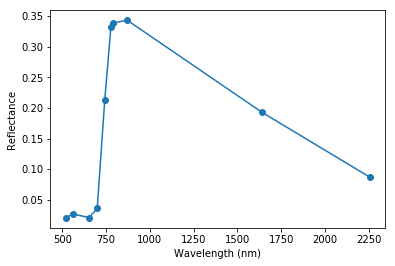

In [57]:
# Plot reflectance by wavelength
import demo
import numpy as np
wavl = demo.sentinel2_wavl()
refl_sub = np.delete(sim.spectra.refl, [0,9,10])
plt.plot(wavl, refl_sub, 'o-')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance')
plt.show()

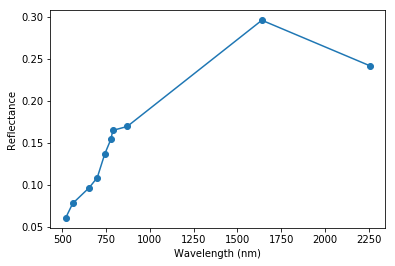

In [60]:
sim.get_land_state = sim.state_default(date_utc=dt.datetime(2016,6,17,9,0), lai=0.2, canopy_ht=0.01, soil_m=0.2)
sim.run_rt = sim.passive_optical
sim.run()
wavl = demo.sentinel2_wavl()
refl_sub = np.delete(sim.spectra.refl, [0,9,10])
plt.plot(wavl, refl_sub, 'o-')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance')
plt.show()

## Example of calculating backscatter for multiple aquisitions
Using the Simulator instance specified in the previous example we show how we can run the simulator for multiple aquisitions. First we specify the dates and view geometries of our observations using a csv file:



In [16]:
sim = ss.Simulator()
sim.get_geom = sim.geom_csv(fname=sim.example_s1_geometries)

Here sim.example_s1_geometries points to an example csv file included with the signaturesimulator package found here:

`
$PYTHONPATH/signaturesimulator/data/geometries/s1_example_const.csv
`

Any geometry csv file must be of the following format:

```
# date, vza, vaa, sza, saa
2016/01/03 05:23,34.3773946043,100.545700717,105.298744327,107.406448412
2016/01/08 05:31,23.4284120953,102.103838392,103.928256857,108.076934788
...
```
We next specify the dates and values for our land surface state variables using a csv file:

In [17]:
sim.get_land_state = sim.state_csv(fname=sim.example_state_variables)

Again we are using an example csv file packaged with the simulator, for the land state csv files must follow the format:
```
# date, lai (m2 m-2), canopy_height (m), soil_moisture (m3 m-3)
2016/01/01 12:00,0.001,0.001,0.339560508728
2016/01/02 12:00,0.001,0.001,0.341959953308
...
```
We can now set the radiative transfer model we wish to use and run the simulator:

In [18]:
sim.run_rt = sim.active_microwave
sim.run()

Once the simulator has finished its run it will write the output to a new backscat class instance. We can see the output variables available to us using:

In [19]:
sim.output_variables

['lai',
 'date_sat_ob',
 'soil_moisture',
 'hv',
 'can_height',
 'date_land_ob',
 'hh',
 'vv']

To plot the backscatter in the hv polaristation we can use the following command:

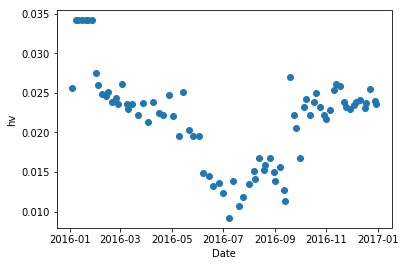

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline
sim.plot('hv')
plt.show()


We can plot any of the output variables using the plot method of the Simulator class, for LAI:

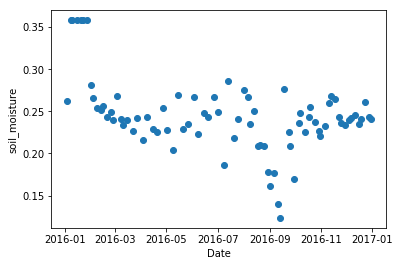

In [32]:
sim.plot('soil_moisture')
plt.show()

Here we can see the effect that leaf area index is having on the simulated observations of backscatter.

## Using JULES to construct estimates to Sentinel 1 and Sentinel 2 observations
JULES models the evolution of the land surface given some meteorological forcing data
![JULES land surface model](jules.png)
Next we show how to take the output of the JULES land surface model and forward model Sentinel 1 backscatters and Sentinel 2 reflectances. Any choice of land surface model could be applied here, these estimates are used as priors in the retrieval tool algorithm.

In [26]:
import signaturesimulator as ss
sim_90 = ss.Simulator()
sim_90.get_geom = sim_90.geom_csv(fname=sim_90.example_s2_geometries)
sim_90.get_land_state = sim_90.state_jules(sim_90.dir_path+'/data/jules/output/jules_90.daily.nc')
sim_90.run_rt = sim_90.passive_optical
sim_90.run()

The output of the JULES model is a netCDF file containing outputed variables specified in the output.nml file in the directory from which JULES has been run. The `state_jules` function of the Simulator class reads the JULES output and extracts the variables required to forward model reflectance and backscatter. Lets look at one of the reflectance bands of Sentinel 2 and then the LAI profile of the crop modelled by JULES.

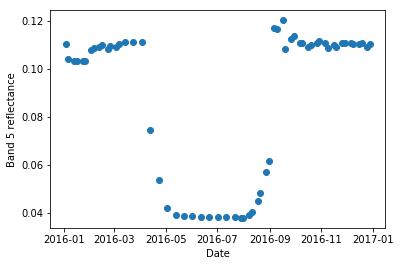

['lai', 'date_sat_ob', 'soil_moisture', 'date_land_ob', 'can_height', 'refl']

In [33]:
import matplotlib.pyplot as plt
sim_90.plot('refl', band_idx=4)
plt.show()
sim_90.output_variables

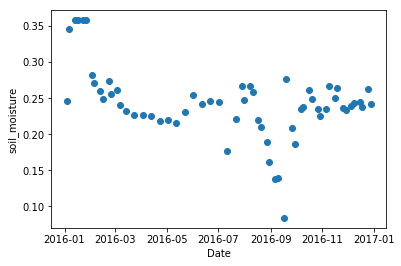

In [31]:
sim_90.plot('soil_moisture')
plt.show()

We can also look at the Normalised Difference Vegetation Index (NDVI) of the crop by plotting a combination of the simulated Satellite reflectance bands (bands 4 and 8).

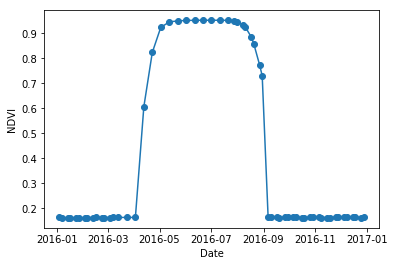

In [39]:
import numpy as np

refl_90 = np.array(sim_90.spectra.refl)
ndvi_90 = (refl_90[:, 7]-refl_90[:, 3])/(refl_90[:, 7]+refl_90[:, 3]) # calculate NDVI for crop sown on 90th day of year
#rvi_90 = refl_90[:, 3]/refl_90[:, 7]
plt.plot(sim_90.get_geom.date_utc, ndvi_90, 'o-')
plt.ylabel('NDVI')
plt.xlabel('Date')
plt.show()

In this example we are modelling maize with JULES (there are 3 other default crops and 5 other PFTs in JULES). We can see the effect that the LAI of the crop is having on the reflectance.

JULES has many different parameters controlling the behaviour of the model, we can vary these to get different estimates of the land surface state and different estimates to the reflectance and backscatter seen by Sentinel 2 and Sentinel 1. For example if we change the crop sow date for maize to day 110 of the year from our original model run of day 90 of the year we find the following update to the LAI of the crop

In [40]:
sim_110 = ss.Simulator()
sim_110.get_geom = sim_110.geom_csv(fname=sim_110.example_s2_geometries)
sim_110.get_land_state = sim_110.state_jules(sim_110.dir_path+'/data/jules/output/jules_110.daily.nc')
sim_110.run_rt = sim_110.passive_optical
sim_110.run()

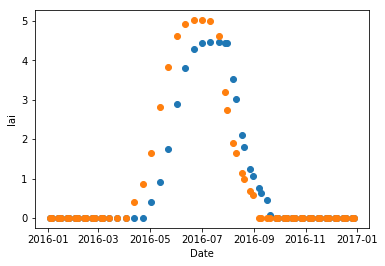

In [44]:
var = 'lai'
sim_110.plot(var,)
sim_90.plot(var,)
plt.show()

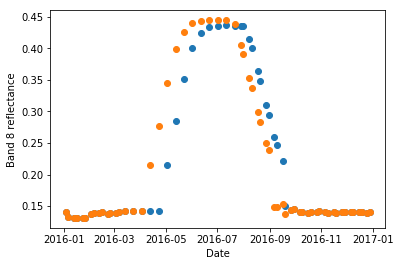

In [47]:
sim_110.plot('refl', band_idx=7)
sim_90.plot('refl', band_idx=7)
plt.show()

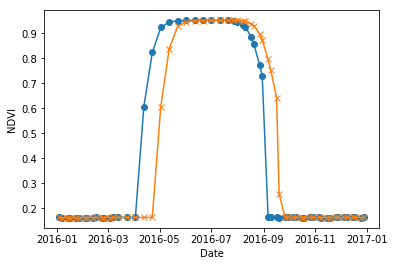

In [48]:
import numpy as np

refl_90 = np.array(sim_90.spectra.refl)
ndvi_90 = (refl_90[:, 7]-refl_90[:, 3])/(refl_90[:, 7]+refl_90[:, 3]) # calculate NDVI for crop sown on 90th day of year
plt.plot(sim_90.get_geom.date_utc, ndvi_90, 'o-')

refl_110 = np.array(sim_110.spectra.refl)
ndvi_110 = (refl_110[:, 7]-refl_110[:, 3])/(refl_110[:, 7]+refl_110[:, 3]) # calculate NDVI for crop sown on 110th day of year
plt.plot(sim_110.get_geom.date_utc, ndvi_110, 'x-')

plt.ylabel('NDVI')
plt.xlabel('Date')
plt.show()